In [1]:
#importing required packages
import numpy as np
import re, tarfile, random
from functools import reduce
import keras
from keras.layers import Dense, Merge, Dropout, RepeatVector, Activation, recurrent
from keras.layers.recurrent import SimpleRNN
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.callbacks import History
from keras import backend as K

#defining the temperatues for the notes 
def sample(preds, temperature):
    # Helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

#Loading abc notation based music file
data = open('input.txt', 'r').read()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print ('Unique characters:', chars)
print ('The data has', data_size, 'characters, with', vocab_size, 'unique characters')

#Vectorizing the data for one hot encoding
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
train_data=data[:int(0.8*data_size)]
val_data = data[int(0.8*data_size):]
seq_len = 25

train_data = [data[i] for i in range(len(data))]
train_data=train_data[:-30]

train_data_onehot = [list(to_categorical(char_to_ix[x],vocab_size)) for x in train_data]

#Loading it to an array
train_data_onehot = np.array(train_data_onehot)




C:\Users\Dhruv Patel\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Unique characters: ['L', 'g', '!', 't', '{', ')', '0', '(', 'D', 'w', '1', 'S', '=', 'c', 'a', 'P', ',', 'O', '|', '5', 'V', 'H', '\t', '^', 'k', '4', '+', '6', ' ', '-', 'm', 'X', 'z', ':', 'u', '~', '@', 'y', '\\', 'j', 'Q', '/', 'C', 'o', '>', 'n', 'E', '*', 'l', 'Z', 'h', 'R', '#', '2', '[', 'G', '\n', 'K', 'd', 'p', 'N', 'J', 's', '<', 'x', '"', '9', 'I', 'Y', '.', 'M', 'f', 'v', ']', '3', 'b', 'r', '?', 'B', 'U', 'q', '7', '_', 'W', 'A', "'", '}', '&', 'e', 'F', 'T', '8', 'i']
The data has 501471 characters, with 93 unique characters


In [2]:
print(len(train_data_onehot))

train_data_onehot 
print(len(train_data))

501441
501441


In [3]:
#Reshaping the data for dividing into train, test and validation
training_batches = np.reshape(train_data_onehot[:-16], (int(train_data_onehot.shape[0]/seq_len), seq_len, vocab_size))

In [4]:
#Splitting the data 

X = training_batches[:,:-1,:]
y = training_batches[:,1:,:]
train_len=int(0.8*training_batches.shape[0])
X_train = X[:train_len,:,:]
y_train = y[:train_len,:,:]
X_valid = X[train_len:,:,:]
y_valid = y[train_len:,:,:]


#Converting to the string
convert2String = lambda y: ''.join([ix_to_char[x[0]] for x in list(np.reshape(np.argmax(y, axis=2), (-1,1)))])

#Defining the model
epochs=100
input_dim = vocab_size
hidden_dim = 100
output_dim = vocab_size
rnn_model = Sequential()
rnn_model.add(SimpleRNN(hidden_dim,
                        activation='tanh', return_sequences = True, input_shape = (None,vocab_size)))
rnn_model.add(Dense(output_dim))
rnn_model.add(Activation('softmax'))
rnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
rnn_model.summary()
print('Training')

#Compiling the model
history = rnn_model.fit(X_train,y_train, batch_size=50, nb_epoch=epochs, validation_data=(X_valid,y_valid))

# Function to get rnn layer output
get_rnn_layer_output = K.function([rnn_model.layers[0].input], [rnn_model.layers[0].output])

prime_len = 25
gen_len = 900
start_index = 0
d =0
rnn_activations = []
for T in [1.0]:
    d +=1
    generated = ''
    sentence = data[start_index: start_index + prime_len]
    generated += sentence
    print ('Generating with seed: "' + sentence + '"')

    for i in range(gen_len):
        x = np.zeros((1, prime_len, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_to_ix[char]] = 1.

        preds = rnn_model.predict(x, verbose=0)[0]
        layer_output = get_rnn_layer_output([x])[0]
        rnn_activations.append(layer_output[0][-1])
        next_index = sample(preds[-1], T)
        next_char = ix_to_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

    f= open('pred_feature2' +'_'+ str(T)+ '_' + str(d) + '.txt','w')
    f.write(generated)
    f.close()
    rnn_activations = np.array(rnn_activations)
    print(rnn_activations.shape)
    np.savetxt('rnn_activations_pred',rnn_activations,delimiter =',')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 100)         19400     
_________________________________________________________________
dense_1 (Dense)              (None, None, 93)          9393      
_________________________________________________________________
activation_1 (Activation)    (None, None, 93)          0         
Total params: 28,793
Trainable params: 28,793
Non-trainable params: 0
_________________________________________________________________
Training


C:\Users\Dhruv Patel\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 16045 samples, validate on 4012 samples
Epoch 1/100
16045/16045 [==============================] - 7s 416us/step - loss: 3.1659 - acc: 0.2142 - val_loss: 2.7333 - val_acc: 0.2541
Epoch 2/100
16045/16045 [==============================] - 8s 478us/step - loss: 2.4255 - acc: 0.3672 - val_loss: 2.4099 - val_acc: 0.3269
Epoch 3/100
16045/16045 [==============================] - 6s 347us/step - loss: 2.1816 - acc: 0.4173 - val_loss: 2.2903 - val_acc: 0.3494
Epoch 4/100
16045/16045 [==============================] - 6s 387us/step - loss: 2.0648 - acc: 0.4369 - val_loss: 2.1904 - val_acc: 0.3714
Epoch 5/100
16045/16045 [==============================] - 7s 417us/step - loss: 1.9897 - acc: 0.4505 - val_loss: 2.1598 - val_acc: 0.3747
Epoch 6/100
16045/16045 [==============================] - 8s 494us/step - loss: 1.9368 - acc: 0.4612 - val_loss: 2.1105 - val_acc: 0.3844
Epoch 7/100
16045/16045 [==============================] - 7s 432us/step - loss: 1.8979 - acc: 0.4681 - val_loss: 2.0

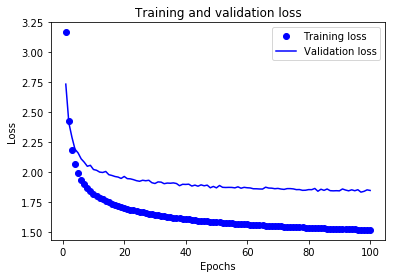

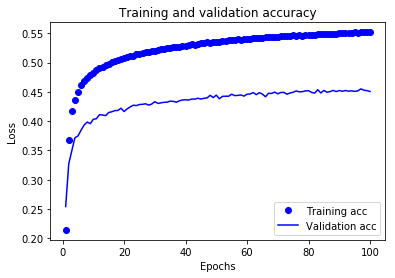

In [6]:
import matplotlib.pyplot as plt
#Validation Graph
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.clf()   # clear figure

#Accuracy Graph
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()